In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
import cv2
from glob import glob 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from tqdm import tqdm_notebook,trange

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
assert tf.__version__ >= "2.0"

import gc
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import itertools
import shutil

np.random.seed(42)
tf.random.set_seed(42)

### Github url: https://github.com/carsonxie/Machine-Learning-Projects/tree/main/CNN%20Cancer%20Detection%20Kaggle%20Mini-Project

### Step 1  Brief description of the problem and data 
Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

**Ans:**

The problem require us to train a model to classfy whether a pathology image contain tumor or not, so it's a binary classification problem. And the images are prepared into 96 by 96 pixels, if the label of this patch is positive then at least 1 pixel of tumor tissue contain in this region, otherwise the label would be 0.

There are 220025 instances in the training set, each training example has two column: id and label. Each unique id is associate with an image in the dataset. And the testset has size of 57458.

And because the train_labels.csv did Not containing the actual image data, we need to write our own image data generator to map the id in train_labels.csv into train/ folder, which the sub folder path is the actual images.

### Step 2 Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In the EDA process, few images were displayed, and base on the tutorial notebooks, some images will cause error were removed. And a histogram shows the numbers of classes is showed below. This is not a balance dataset. Class 0 have more samples.

In [2]:
#load data
my_dir = '../input/histopathologic-cancer-detection'
print('Files in dir:', os.listdir(my_dir))

df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

# removing this image because it caused a training error previously
df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df.shape)

Files in dir: ['sample_submission.csv', 'train_labels.csv', 'test', 'train']
(220025, 2)


0    130908
1     89117
Name: label, dtype: int64


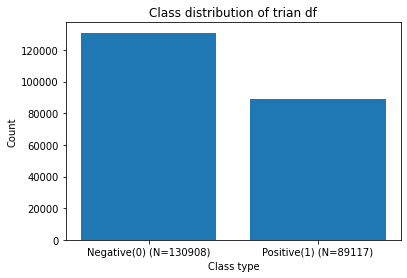

In [3]:
class_count = df['label'].value_counts()
print(class_count)
plt.bar([0,1], [class_count[0],class_count[1]])
plt.ylabel("Count")
plt.xlabel("Class type")
plt.xticks([0,1],["Negative(0) (N={})".format(class_count[0]),"Positive(1) (N={})".format(class_count[1])])
plt.title("Class distribution of trian df");
plt.show()

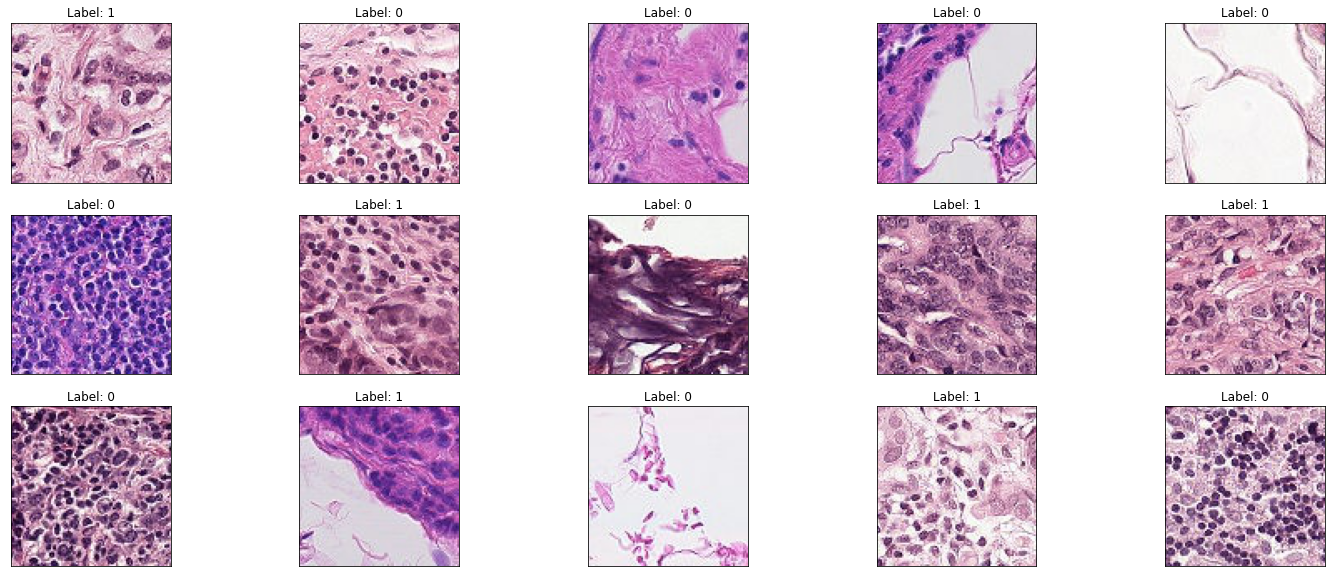

In [4]:
# lets see how's some images look like
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
fig = plt.figure(figsize=(25, 10))
train_imgs = os.listdir("../input/histopathologic-cancer-detection/train")
for idx, img in enumerate(np.random.choice(train_imgs, 15)):
    ax = fig.add_subplot(3, 5, idx+1, xticks=[], yticks=[])
    im = Image.open("../input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

### Load data

In [5]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
# stratify=y creates a balanced validation set.
y = df['label']

df_train, df_val = train_test_split(df, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(198022, 2)
(22003, 2)


In [7]:
# create data folder
# 


# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)


In [8]:
os.listdir('base_dir/train_dir')

['b_has_tumor_tissue', 'a_no_tumor_tissue']

##### Transfer the images into the folders

In [9]:
# Set the id as the index in df_data
df.set_index('id', inplace=True)
df.head()

,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
# Get a list of train and val images
# only need to run once 
##########
train_list = list(df_train['id'])
val_list = list(df_val['id'])



# Transfer the train images
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [11]:
print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

117817
80205


In [12]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3


train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 16  #10 
val_batch_size = 16


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
print(train_steps, val_steps)

12377.0 1376.0


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


###  Step 3 Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

Since this is a image classification problem, first architecture came into mind is a Alex net like model. Input is image is (96 96 3), try filters size wiht 64, 96, 256 denpend on the compputation time.
Also add batch norm after each layer, and dropout, l1 regularization.

1. input 96 96 3
2. (conv2d->batch norm->pooling->dropout) *3. filter size 32 ->64 ->96
3. Dense layer 256
4. Softmax output

* After first try, the model is to larger which is extremely slow to train, so I add more pooling layers after each Conv2D layers to reduce filter dimensions, therefore reduce the complexity of model. Although the score is a litte lower(about 2%) but the training speed is much faster.

* Also, to increase training speed, the inital learning rate for optimizer is set to a large number 0.01, seem the Adam optimizer is will self adjust lr during training. A ReduceLROnPlateau() class is setted to reduce learning rate during epochs increase.

In [14]:
#model architecture 1

keras.backend.clear_session()
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,kernel_initializer="he_normal",
                        kernel_size=(3,3), activation='relu', padding="SAME")
model = keras.models.Sequential([
    DefaultConv2D(filters=32,input_shape=(96,96,3)),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=32),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    DefaultConv2D(filters=32),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate=0.3),
    
    DefaultConv2D(filters=64),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    DefaultConv2D(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate=0.3),
    
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(pool_size=(2,2)),
    DefaultConv2D(filters=128,kernel_regularizer=keras.regularizers.l1(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(3,3)),
    keras.layers.Dropout(rate=0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(2, activation='softmax')
    
])

model.summary()

2022-03-30 03:24:05.788911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 03:24:05.876265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 03:24:05.877002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 03:24:05.879428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        1

In [15]:
# train model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [16]:
#filepath = "model.h5"
filepath = "./model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_freq='epoch', mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=15, verbose=1,
                   callbacks=callbacks_list)

2022-03-30 03:24:08.921824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-03-30 03:24:11.173348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12377/12377 [==============================] - 373s 29ms/step - loss: 2.6226 - accuracy: 0.8304 - val_loss: 2.2687 - val_accuracy: 0.8569

Epoch 00001: saving model to ./model.h5
Epoch 2/15
12377/12377 [==============================] - 302s 24ms/step - loss: 2.2821 - accuracy: 0.8742 - val_loss: 2.1833 - val_accuracy: 0.9083

Epoch 00002: saving model to ./model.h5
Epoch 3/15
12377/12377 [==============================] - 264s 21ms/step - loss: 2.3128 - accuracy: 0.8912 - val_loss: 2.5217 - val_accuracy: 0.7856

Epoch 00003: saving model to ./model.h5
Epoch 4/15
12377/12377 [==============================] - 260s 21ms/step - loss: 2.3709 - accuracy: 0.9003 - val_loss: 2.4860 - val_accuracy: 0.9259

Epoch 00004: saving model to ./model.h5
Epoch 5/15
12377/12377 [==============================] - 259s 21ms/step - loss: 2.3518 - accuracy: 0.9073 - val_loss: 2.3092 - val_accuracy: 0.9173

Epoch 00005: saving model to ./model.h5
Epoch 6/15
12377/12377 [==============================] - 259

In [17]:
model.save("./output/model_final.h5")

In [18]:
#model.load_weights('./model.h5')  

val_loss, val_acc = model.evaluate(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

22003/22003 [==============================] - 94s 4ms/step - loss: 2378.8489 - accuracy: 0.9274
val_loss: 2378.848876953125
val_acc: 0.9273735284805298


### Step 4 Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

1. Learning rate set to 0.01 produce good balance between speed and accuracy. 
2. Tricks that help to imporve result and reduce overfitting and faster training/better model were used: batch normalization, dropout, l1.
3. Number of epochs, of course 10 is better than 5, and 15 is better than 10. Due to trainng time, I have tried up to 20, and it produce decent result(over 90% acc).
4. Further techniques can be applied: data augmentation, crop, zoom, randomly change brightness of images etc. All provid in ImageDataGenerator() class.
5. Hyperparameters summary: 
 * epochs:15
 * optimizers: Adam with lr=0.01
 * kernel size (3,3) with valid padding,
 * number of filters : 32 - 64 -96
 * relu activation
 * dropout rate: 0.3 for Conv2D, 0.3 for dense layer.
 

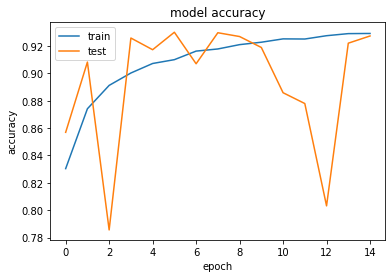

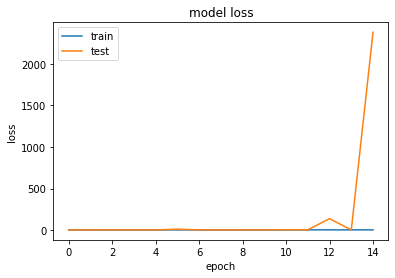

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [20]:
#predict on test set
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

22003/22003 [==============================] - 74s 3ms/step


In [21]:
test_gen.class_indices
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
y_true = test_gen.classes
y_pred = df_preds['has_tumor_tissue']

In [22]:
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13091
           1       0.90      0.93      0.91      8912

    accuracy                           0.93     22003
   macro avg       0.92      0.93      0.93     22003
weighted avg       0.93      0.93      0.93     22003



### Step 5 Conclusion (15 pts)
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

* Model accuracy on validation set: 0.93  ， recall: 0.93,  f1 score: 0.93
* Somehow the loss plot is Not smooth and very unstable, normally loss plot will gradually decrese, one possible reason: learning rate is too large.
* Increse number of epochs imporve the result most obviously, at least while epoch <= 20, maybe model arch will have it limit after reach certain epochs. This can be the "try in future".
* Other tricks like batch norm, dropout did improve the model.
* Data augmantation I choose zoom_range and brightness_range, hard to say how much these help on the final result, but it reduce the training speed quit a lot, before apply these one epoch took about 8min, after need 12 mins. And among the choices of data augmentation which is more effective than others can be the "try in future" thing consider in this problem the data is large.
* This network architecture seems reach it limits after 20 epochs, next time we can try a more complex model like SENet, ResNet or other pretrain model.

###  Step 6
Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (35 points)

url:  https://github.com/carsonxie/Machine-Learning-Projects/tree/main/CNN%20Cancer%20Detection%20Kaggle%20Mini-Project


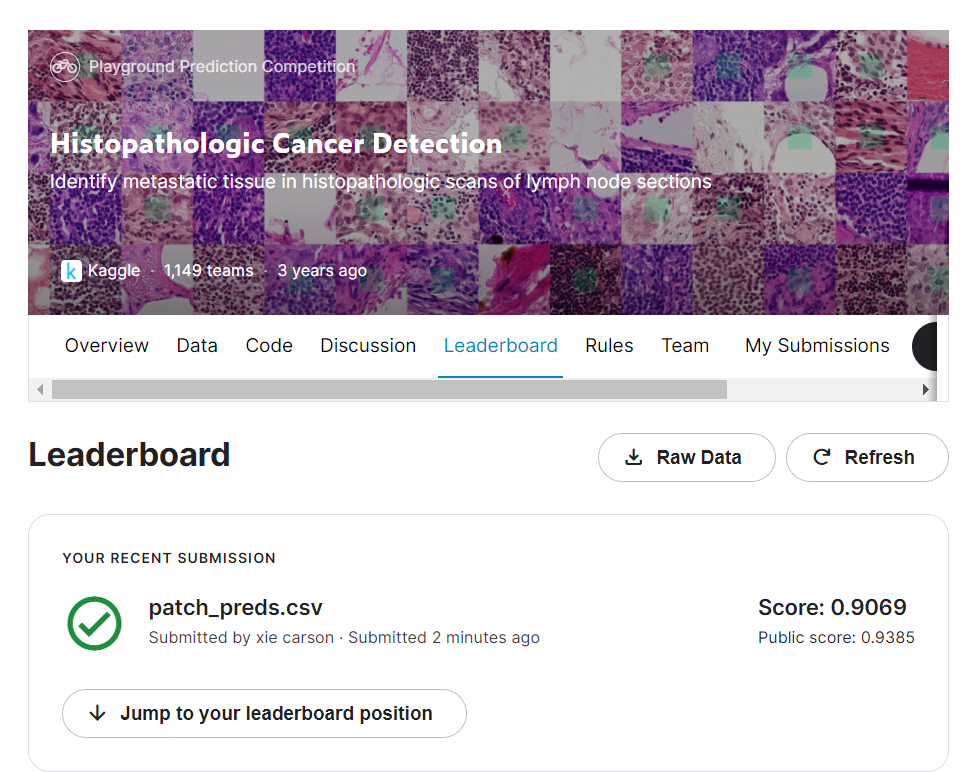




______________

Reference notebooks: 
https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing



________________________________________
code for create submission file

In [23]:
# create submission file
#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]

# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# test_dir
    # test_images

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [24]:
os.listdir('test_dir')

['test_images']

In [25]:
# Transfer the test images into image_dir

test_list = os.listdir('../input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../input/histopathologic-cancer-detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [26]:
len(os.listdir('test_dir/test_images'))

57458

In [27]:
test_path ='test_dir'


# Here we change the path to point to the test_images folder.

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [28]:
num_test_images = 57458

# make sure we are using the best epoch
model.load_weights('model.h5')

predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 195s 3ms/step


In [29]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,9.593066e-05,9.999040e-01
1,1.332911e-07,9.999999e-01
2,5.875490e-01,4.124511e-01
3,9.994127e-01,5.874080e-04
4,1.000000e+00,5.675551e-08


In [30]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,9.593066e-05,9.999040e-01,test_images/00006537328c33e284c973d7b39d340809...
1,1.332911e-07,9.999999e-01,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,5.875490e-01,4.124511e-01,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,9.994127e-01,5.874080e-04,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,1.000000e+00,5.675551e-08,test_images/000270442cc15af719583a8172c87cd2bd...


In [31]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b


def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,9.593066e-05,9.999040e-01,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,1.332911e-07,9.999999e-01,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,5.875490e-01,4.124511e-01,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,9.994127e-01,5.874080e-04,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,1.000000e+00,5.675551e-08,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [32]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [33]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('./patch_preds.csv', columns=['label']) 

In [34]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,9.999040e-01
0000ec92553fda4ce39889f9226ace43cae3364e,9.999999e-01
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,4.124511e-01
000253dfaa0be9d0d100283b22284ab2f6b643f6,5.874080e-04
000270442cc15af719583a8172c87cd2bd9c7746,5.675551e-08


In [35]:
shutil.rmtree('test_dir')